Directorio actual: C:\Users\Jorge Moya\Documents\Academic\I.T.E.S.M\M.E. Inteligencia Artificial Aplicada\4to Trimestre\Operaciones de aprendizaje automático\Tareas o Trabajos\ml-CEE_DATA-project

Buscando hiperparámetros para RandomForest...
Mejor F1: 0.687
Mejores parámetros: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'n_estimators': 500}

Buscando hiperparámetros para XGBoost...


C:\Users\Jorge Moya\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:18:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Mejor F1: 0.691
Mejores parámetros: {'colsample_bytree': 0.8, 'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.8}

Buscando hiperparámetros para LogisticRegression...


C:\Users\Jorge Moya\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Mejor F1: 0.556
Mejores parámetros: {'C': 10, 'solver': 'saga'}

Buscando hiperparámetros para CatBoost...
Mejor F1: 0.696
Mejores parámetros: {'depth': 6, 'l2_leaf_reg': 1, 'learning_rate': 0.03}

Resultados finales RandomForest
              precision    recall  f1-score   support

           0       0.89      0.84      0.87       346
           1       0.84      0.95      0.89       346
           2       0.86      0.81      0.83       346

    accuracy                           0.87      1038
   macro avg       0.87      0.87      0.86      1038
weighted avg       0.87      0.87      0.86      1038



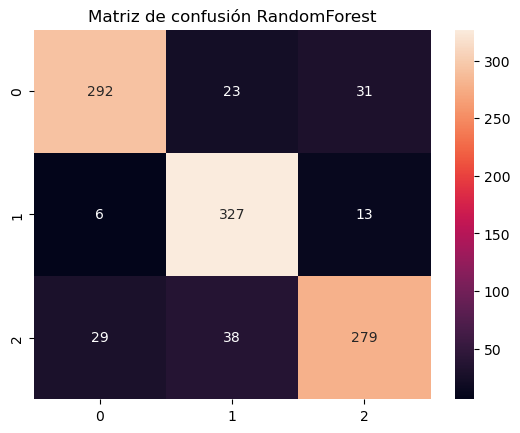

Modelo guardado en: models/RandomForest_best_model.pkl

Resultados finales XGBoost
              precision    recall  f1-score   support

           0       0.86      0.84      0.85       346
           1       0.87      0.90      0.89       346
           2       0.82      0.82      0.82       346

    accuracy                           0.85      1038
   macro avg       0.85      0.85      0.85      1038
weighted avg       0.85      0.85      0.85      1038



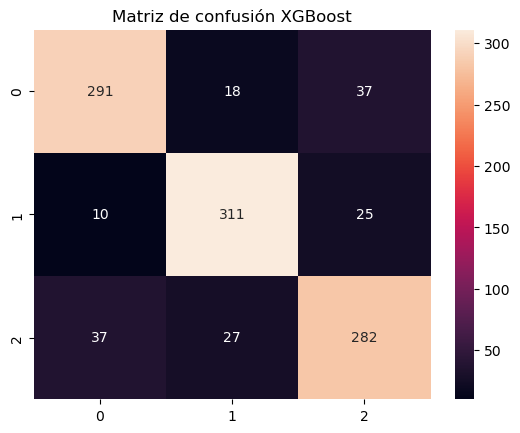

Modelo guardado en: models/XGBoost_best_model.pkl

Resultados finales LogisticRegression
              precision    recall  f1-score   support

           0       0.62      0.69      0.65       346
           1       0.56      0.65      0.60       346
           2       0.53      0.38      0.45       346

    accuracy                           0.58      1038
   macro avg       0.57      0.58      0.57      1038
weighted avg       0.57      0.58      0.57      1038



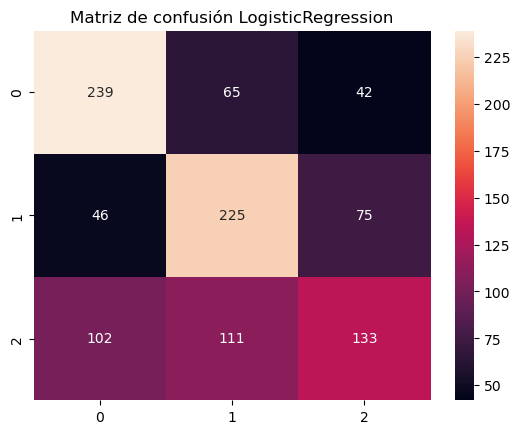

Modelo guardado en: models/LogisticRegression_best_model.pkl

Resultados finales CatBoost
              precision    recall  f1-score   support

           0       0.90      0.84      0.87       346
           1       0.88      0.91      0.90       346
           2       0.82      0.84      0.83       346

    accuracy                           0.86      1038
   macro avg       0.86      0.86      0.86      1038
weighted avg       0.86      0.86      0.86      1038



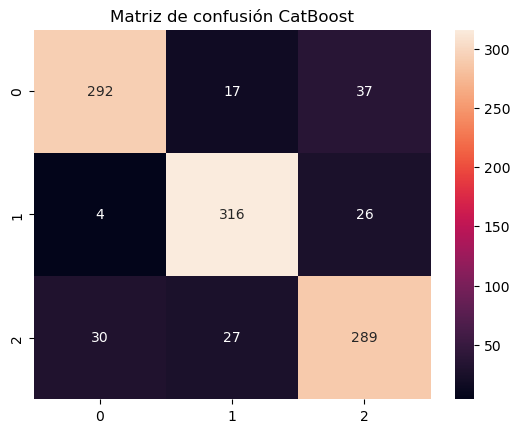

Modelo guardado en: models/CatBoost_best_model.pkl


In [1]:
import pickle
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import make_scorer, f1_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from catboost import CatBoostClassifier
import seaborn as sns
import matplotlib.pyplot as plt
import os
import joblib

os.chdir("..")  # Moverse desde /notebooks al directorio raíz del proyecto
print("Directorio actual:", os.getcwd())

with open("data/processed/Xy_resampled.pkl","rb") as f:
    X_res, y_res = pickle.load(f)

models = {
    'RandomForest':{'model':RandomForestClassifier(random_state=42),'params':{'n_estimators':[300,500],'max_depth':[5,10,None],'min_samples_leaf':[1,3,5],'max_features':['sqrt','log2']}},
    'XGBoost':{'model':XGBClassifier(use_label_encoder=False, eval_metric='mlogloss', random_state=42),'params':{'n_estimators':[300,500],'max_depth':[3,4,5],'learning_rate':[0.05,0.08,0.1],'subsample':[0.7,0.8],'colsample_bytree':[0.7,0.8]}},
    'LogisticRegression':{'model':LogisticRegression(multi_class='multinomial', max_iter=2000, random_state=42),'params':{'C':[0.1,1,10],'solver':['lbfgs','saga']}},
    'CatBoost':{'model':CatBoostClassifier(iterations=800, verbose=0, random_seed=42),'params':{'depth':[4,6,8],'learning_rate':[0.03,0.05,0.08],'l2_leaf_reg':[1,3,5]}}
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
f1_scorer = make_scorer(f1_score, average='macro')
best_models = {}

for name,m in models.items():
    print(f"\nBuscando hiperparámetros para {name}...")
    gs = GridSearchCV(m['model'], m['params'], cv=cv, scoring=f1_scorer, n_jobs=-1)
    gs.fit(X_res, y_res)
    print(f"Mejor F1: {gs.best_score_:.3f}")
    print("Mejores parámetros:", gs.best_params_)
    best_models[name] = gs.best_estimator_

for name, model in best_models.items():
    print(f"\nResultados finales {name}")
    y_pred = model.predict(X_res)
    print(classification_report(y_res, y_pred))
    cm = confusion_matrix(y_res, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.title(f'Matriz de confusión {name}')
    plt.show()
    model_path = f"models/{name}_best_model.pkl"
    joblib.dump(model, model_path)
    print(f"Modelo guardado en: {model_path}")